In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
files=glob.glob('C:/Users/91750/Desktop/VLG/negative/*')

In [3]:
l=[pd.read_csv(filename,sep='\t',names=["text"],) for filename in files]
df=pd.concat(l,axis=0)

In [4]:
df['labels']=0

In [5]:
df.head()

,text,labels
0,possibly the worst book i have ever read while...,0
0,boring with a total lack of clarity i had neve...,0
0,not good science while i appreciate what tiple...,0
0,calvino could have written better stuff this b...,0
0,excellent book marred by slander as many revie...,0


In [6]:
files_=glob.glob('C:/Users/91750/Desktop/VLG/positive/*')

In [7]:
m=[pd.read_csv(filename,sep='\t',names=["text"],) for filename in files_]
df2=pd.concat(m,axis=0)

In [8]:
df2['label']=1

In [9]:
df2.head()

,text,label
0,greatest spy thriller this is the true account...,1
0,rick steves books are the best i love the way ...,1
0,"fascinating as a geography and history buff , ...",1
0,plymoth we were very pleased with our books . ...,1
0,is it reality or a blend of reality and fantas...,1


In [10]:
train=pd.concat([df,df2],axis=0)

In [11]:
train.head()

,text,labels,label
0,possibly the worst book i have ever read while...,0.0,NaN
0,boring with a total lack of clarity i had neve...,0.0,NaN
0,not good science while i appreciate what tiple...,0.0,NaN
0,calvino could have written better stuff this b...,0.0,NaN
0,excellent book marred by slander as many revie...,0.0,NaN


In [12]:
train.drop('labels',axis=1,inplace=True)

In [13]:
train.fillna(0,axis=1,inplace=True)

In [14]:
train.head()

,text,label
0,possibly the worst book i have ever read while...,0.0
0,boring with a total lack of clarity i had neve...,0.0
0,not good science while i appreciate what tiple...,0.0
0,calvino could have written better stuff this b...,0.0
0,excellent book marred by slander as many revie...,0.0


In [15]:
train['length'] = train['text'].apply(len)

In [16]:
#average length of document in training dataset
train['length'].mean()

963.3975

In [17]:
#max length of document in training dataset
train['length'].max()

20775

In [18]:
#function to remove punctuations
import re
def clean_data(text):
    text = re.sub('[^a-zA-Z]', ' ',text)
    text = text.lower()
    return text

In [19]:
train['text'] = train['text'].apply(clean_data)

In [20]:
train['unique']=train.text.apply(lambda x: len(set(x.split())))

In [21]:
#unique words
train['unique'].sum()

199400

In [22]:
#total number of training examples
len(train)

2000

In [23]:
#ratio of positive examples to negative examples
ratio=len(train[train['label']==1])/len(train[train['label']==0])
ratio

1.0

In [24]:
import nltk
from nltk.corpus import stopwords

In [25]:
def remove_stop_words(text):
    li = []
    stop_words = stopwords.words('english')
    text = text.split()
    text = [li.append(word) for word in text if word not in stop_words]
    text = ' '.join(li)
    return text

In [26]:
train['text'] = train['text'].apply(remove_stop_words)

In [27]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

def lematize(text):
    text = text.split()
    text = [lemmatizer.lemmatize(w) for w in text]
    text = ' '.join(text)
    return text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91750\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
train['text'] = train['text'].apply(lematize)

In [29]:
train.head()

,text,label,length,unique
0,possibly worst book ever read realize majority...,0.0,676,80
0,boring total lack clarity never read vernor vi...,0.0,814,93
0,good science appreciate tipler attempting acco...,0.0,169,25
0,calvino could written better stuff book say no...,0.0,147,25
0,excellent book marred slander many reviewer co...,0.0,1078,117


In [30]:
train=train.drop(['length','unique'],axis=1)

In [31]:
train.head()

,text,label
0,possibly worst book ever read realize majority...,0.0
0,boring total lack clarity never read vernor vi...,0.0
0,good science appreciate tipler attempting acco...,0.0
0,calvino could written better stuff book say no...,0.0
0,excellent book marred slander many reviewer co...,0.0


In [32]:
train_X=train['text']
train_Y=train['label']

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(train_X, train_Y , test_size = 0.20, random_state=7)

In [34]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()

tokenizer.fit_on_texts(list(X_train))

X_train_seq  = tokenizer.texts_to_sequences(X_train) 
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq  = pad_sequences(X_train_seq, maxlen=100)
X_test_seq = pad_sequences(X_test_seq, maxlen=100)

In [49]:
size_of_vocabulary=len(tokenizer.word_index) + 1
print(size_of_vocabulary)

17304


# RNN MODEL without pretrained embedding

In [50]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *


model=Sequential()

model.add(Embedding(size_of_vocabulary,300,input_length=100,trainable=True)) 

model.add(LSTM(100,return_sequences=True,activation='tanh'))

model.add(GlobalMaxPooling1D())

model.add(Dense(100))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          5191200   
                                                                 
 lstm_4 (LSTM)               (None, 100, 100)          160400    
                                                                 
 global_max_pooling1d_4 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,361,801
Trainable params: 5,361,801
Non-trainable params: 0
____________________________________________

In [54]:
from time import time
start=time()

In [55]:
history = model.fit(np.array(X_train_seq),np.array(y_train),epochs=30,validation_data=(np.array(X_test_seq),np.array(y_test)),verbose=1,callbacks=[es,mc])

Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 0.0011 - acc: 1.0000
Epoch 00001: val_acc improved from 0.74250 to 0.75250, saving model to best_model.h5
50/50 [==============================] - 6s 117ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 1.3189 - val_acc: 0.7525
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 3.6352e-04 - acc: 1.0000
Epoch 00002: val_acc did not improve from 0.75250
50/50 [==============================] - 6s 115ms/step - loss: 3.6352e-04 - acc: 1.0000 - val_loss: 1.4578 - val_acc: 0.7525
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 2.0848e-04 - acc: 1.0000
Epoch 00003: val_acc improved from 0.75250 to 0.75500, saving model to best_model.h5
50/50 [==============================] - 6s 116ms/step - loss: 2.0848e-04 - acc: 1.0000 - val_loss: 1.5510 - val_acc: 0.7550
Epoch 4/30
50/50 [==============================] - ETA: 0s - loss: 1.4707e-04 - acc: 1.0000
Epoch 00004: val_acc improved from 0.7550

In [56]:
#training time till best accuracy

print(time()-start)

25.352086782455444


In [59]:
from keras.models import load_model
model = load_model('best_model.h5')

#max accuracy

_,val_acc = model.evaluate(X_test_seq,y_test)
print(val_acc)

13/13 [==============================] - 1s 21ms/step - loss: 1.6393 - acc: 0.7575
0.7574999928474426


In [60]:
#Preparing to plot graph for 30 epochs

model=Sequential()

model.add(Embedding(size_of_vocabulary,300,input_length=100,trainable=True)) 

model.add(LSTM(100,return_sequences=True,activation='tanh'))

model.add(GlobalMaxPooling1D())

model.add(Dense(100))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

history = model.fit(np.array(X_train_seq),np.array(y_train),epochs=30,validation_data=(np.array(X_test_seq),np.array(y_test)),verbose=1)

Epoch 1/30
50/50 [==============================] - 8s 132ms/step - loss: 0.6675 - acc: 0.5900 - val_loss: 0.7203 - val_acc: 0.5850
Epoch 2/30
50/50 [==============================] - 6s 118ms/step - loss: 0.2771 - acc: 0.8950 - val_loss: 0.6335 - val_acc: 0.7475
Epoch 3/30
50/50 [==============================] - 7s 133ms/step - loss: 0.0400 - acc: 0.9862 - val_loss: 0.6893 - val_acc: 0.7550
Epoch 4/30
50/50 [==============================] - 6s 114ms/step - loss: 0.0082 - acc: 0.9981 - val_loss: 1.1564 - val_acc: 0.7400
Epoch 5/30
50/50 [==============================] - 6s 115ms/step - loss: 5.0154e-04 - acc: 1.0000 - val_loss: 1.3458 - val_acc: 0.7350
Epoch 6/30
50/50 [==============================] - 6s 116ms/step - loss: 2.1392e-04 - acc: 1.0000 - val_loss: 1.4680 - val_acc: 0.7300
Epoch 7/30
50/50 [==============================] - 6s 122ms/step - loss: 1.4658e-04 - acc: 1.0000 - val_loss: 1.5683 - val_acc: 0.7350
Epoch 8/30
50/50 [==============================] - 6s 124ms/ste

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


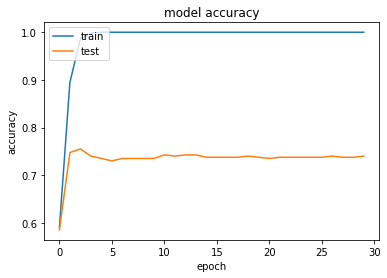

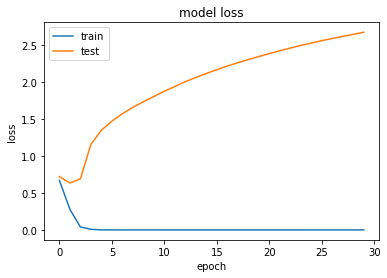

In [61]:
#Graphs for 30 epochs

print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Importing Embeddings

In [63]:
import os
import zipfile
with zipfile.ZipFile("C:/Users/91750/Downloads/glove.6B.300d.txt.zip", 'r') as zip_ref:
    zip_ref.extractall("C:/Users/91750/Desktop/VLG")

In [64]:
embeddings_index = dict()
f = open("C:/Users/91750/Desktop/VLG/glove.6B.300d.txt",encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [65]:
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# RNN MODEL with pretrained embedding

In [66]:
model=Sequential()

model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=100,trainable=True)) 

model.add(LSTM(100,return_sequences=True,activation='tanh'))

model.add(GlobalMaxPooling1D())

model.add(Dense(100))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 300)          5191200   
                                                                 
 lstm_6 (LSTM)               (None, 100, 100)          160400    
                                                                 
 global_max_pooling1d_6 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 5,361,801
Trainable params: 5,361,801
Non-trainable params: 0
____________________________________________

In [67]:
start=time()

In [68]:
history = model.fit(np.array(X_train_seq),np.array(y_train),epochs=30,validation_data=(np.array(X_test_seq),np.array(y_test)),verbose=1,callbacks=[es,mc])

Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 0.5766 - acc: 0.6812
Epoch 00001: val_acc improved from -inf to 0.76000, saving model to best_model.h5
50/50 [==============================] - 8s 135ms/step - loss: 0.5766 - acc: 0.6812 - val_loss: 0.5134 - val_acc: 0.7600
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 0.3139 - acc: 0.8662
Epoch 00002: val_acc improved from 0.76000 to 0.78250, saving model to best_model.h5
50/50 [==============================] - 6s 125ms/step - loss: 0.3139 - acc: 0.8662 - val_loss: 0.4963 - val_acc: 0.7825
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 0.1355 - acc: 0.9550
Epoch 00003: val_acc improved from 0.78250 to 0.79250, saving model to best_model.h5
50/50 [==============================] - 6s 125ms/step - loss: 0.1355 - acc: 0.9550 - val_loss: 0.5878 - val_acc: 0.7925
Epoch 4/30
50/50 [==============================] - ETA: 0s - loss: 0.0425 - acc: 0.9900
Epoch 00004: val_acc did not 

In [69]:
#training time till best accuracy

print(time()-start)

34.47403168678284


In [70]:
model = load_model('best_model.h5')

#max accuracy

_,val_acc = model.evaluate(X_test_seq,y_test)
print(val_acc)

13/13 [==============================] - 1s 21ms/step - loss: 0.5878 - acc: 0.7925
0.7925000190734863


In [71]:
#Preparing to plot graph for 30 epochs

model=Sequential()

model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=100,trainable=True)) 

model.add(LSTM(100,return_sequences=True,activation='tanh'))

model.add(GlobalMaxPooling1D())

model.add(Dense(100))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

history = model.fit(np.array(X_train_seq),np.array(y_train),epochs=30,validation_data=(np.array(X_test_seq),np.array(y_test)),verbose=1)

Epoch 1/30
50/50 [==============================] - 8s 135ms/step - loss: 0.6683 - acc: 0.5744 - val_loss: 0.5854 - val_acc: 0.7175
Epoch 2/30
50/50 [==============================] - 6s 123ms/step - loss: 0.3937 - acc: 0.8537 - val_loss: 0.5163 - val_acc: 0.7525
Epoch 3/30
50/50 [==============================] - 6s 123ms/step - loss: 0.1688 - acc: 0.9463 - val_loss: 0.6178 - val_acc: 0.7850
Epoch 4/30
50/50 [==============================] - 6s 122ms/step - loss: 0.0549 - acc: 0.9881 - val_loss: 0.7266 - val_acc: 0.7750
Epoch 5/30
50/50 [==============================] - 6s 122ms/step - loss: 0.0137 - acc: 0.9969 - val_loss: 0.7589 - val_acc: 0.8000
Epoch 6/30
50/50 [==============================] - 6s 122ms/step - loss: 0.0046 - acc: 0.9994 - val_loss: 1.1577 - val_acc: 0.7875
Epoch 7/30
50/50 [==============================] - 6s 122ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 1.2240 - val_acc: 0.7800
Epoch 8/30
50/50 [==============================] - 6s 122ms/step - loss: 4.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


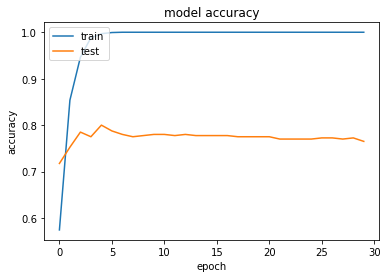

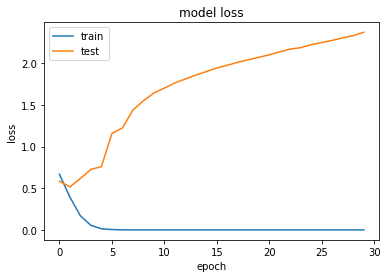

In [72]:
#Graphs for 30 epochs

print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CNN MODEL without pretrained embedding

In [73]:
model = Sequential()

model.add(Embedding(size_of_vocabulary, 300, input_length=100))
          
model.add(Conv1D(100, 3, activation='relu'))
          
model.add(GlobalMaxPooling1D())
          
model.add(Dense(100))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 300)          5191200   
                                                                 
 conv1d (Conv1D)             (None, 98, 100)           90100     
                                                                 
 global_max_pooling1d_8 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_16 (Dense)            (None, 100)               10100     
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                                 
Total params: 5,291,501
Trainable params: 5,291,501
Non-trainable params: 0
____________________________________________

In [74]:
start=time()

In [75]:
history = model.fit(np.array(X_train_seq),np.array(y_train),epochs=30,validation_data=(np.array(X_test_seq),np.array(y_test)),verbose=1,callbacks=[es,mc])

Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 0.6715 - acc: 0.5987
Epoch 00001: val_acc improved from -inf to 0.69750, saving model to best_model.h5
50/50 [==============================] - 4s 80ms/step - loss: 0.6715 - acc: 0.5987 - val_loss: 0.6177 - val_acc: 0.6975
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 0.3225 - acc: 0.9331
Epoch 00002: val_acc improved from 0.69750 to 0.78250, saving model to best_model.h5
50/50 [==============================] - 4s 78ms/step - loss: 0.3225 - acc: 0.9331 - val_loss: 0.4729 - val_acc: 0.7825
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 0.0245 - acc: 0.9994
Epoch 00003: val_acc did not improve from 0.78250
50/50 [==============================] - 4s 80ms/step - loss: 0.0245 - acc: 0.9994 - val_loss: 0.4818 - val_acc: 0.7775
Epoch 4/30
50/50 [==============================] - ETA: 0s - loss: 0.0028 - acc: 1.0000
Epoch 00004: val_acc did not improve from 0.78250
50/50 [==========

In [76]:
#training time till best accuracy

print(time()-start)

24.063377141952515


In [77]:
model = load_model('best_model.h5')

#max accuracy

_,val_acc = model.evaluate(X_test_seq,y_test)
print(val_acc)

13/13 [==============================] - 0s 5ms/step - loss: 0.4729 - acc: 0.7825
0.7825000286102295


In [78]:
#Preparing to plot graph for 30 epochs

model = Sequential()

model.add(Embedding(size_of_vocabulary, 300, input_length=100))
          
model.add(Conv1D(100, 3, activation='relu'))
          
model.add(GlobalMaxPooling1D())
          
model.add(Dense(100))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

history = model.fit(np.array(X_train_seq),np.array(y_train),epochs=30,validation_data=(np.array(X_test_seq),np.array(y_test)),verbose=1)

Epoch 1/30
50/50 [==============================] - 4s 82ms/step - loss: 0.6689 - acc: 0.5969 - val_loss: 0.6437 - val_acc: 0.6450
Epoch 2/30
50/50 [==============================] - 4s 76ms/step - loss: 0.3409 - acc: 0.9069 - val_loss: 0.5218 - val_acc: 0.7225
Epoch 3/30
50/50 [==============================] - 4s 82ms/step - loss: 0.0344 - acc: 0.9956 - val_loss: 0.5180 - val_acc: 0.7450
Epoch 4/30
50/50 [==============================] - 4s 89ms/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.5370 - val_acc: 0.7500
Epoch 5/30
50/50 [==============================] - 4s 86ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.5519 - val_acc: 0.7450
Epoch 6/30
50/50 [==============================] - 4s 89ms/step - loss: 9.9431e-04 - acc: 1.0000 - val_loss: 0.5615 - val_acc: 0.7500
Epoch 7/30
50/50 [==============================] - 4s 89ms/step - loss: 6.9924e-04 - acc: 1.0000 - val_loss: 0.5714 - val_acc: 0.7525
Epoch 8/30
50/50 [==============================] - 4s 89ms/step - loss: 5.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


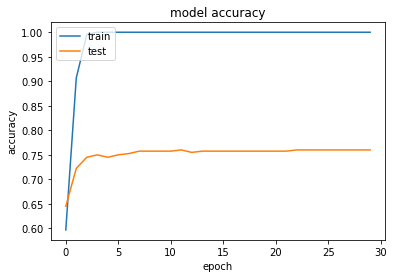

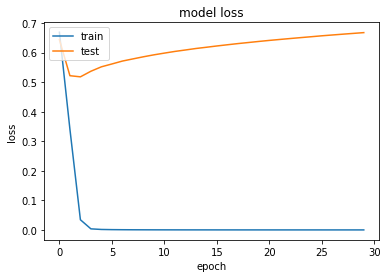

In [79]:
#Graphs for 30 epochs

print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# CNN MODEL with pretrained embedding

In [85]:
model = Sequential()

model.add(Embedding(size_of_vocabulary, 300, weights=[embedding_matrix], input_length=100))
          
model.add(Conv1D(100, 3, activation='relu'))
          
model.add(GlobalMaxPooling1D())
          
model.add(Dense(100))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 300)          5191200   
                                                                 
 conv1d_3 (Conv1D)           (None, 98, 100)           90100     
                                                                 
 global_max_pooling1d_11 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_22 (Dense)            (None, 100)               10100     
                                                                 
 dense_23 (Dense)            (None, 1)                 101       
                                                                 
Total params: 5,291,501
Trainable params: 5,291,501
Non-trainable params: 0
___________________________________________

In [86]:
start=time()

In [87]:
history = model.fit(np.array(X_train_seq),np.array(y_train),epochs=30,validation_data=(np.array(X_test_seq),np.array(y_test)),verbose=1,callbacks=[es,mc])

Epoch 1/30
50/50 [==============================] - ETA: 0s - loss: 0.6313 - acc: 0.6562
Epoch 00001: val_acc improved from -inf to 0.72250, saving model to best_model.h5
50/50 [==============================] - 4s 81ms/step - loss: 0.6313 - acc: 0.6562 - val_loss: 0.5584 - val_acc: 0.7225
Epoch 2/30
50/50 [==============================] - ETA: 0s - loss: 0.2317 - acc: 0.9606
Epoch 00002: val_acc improved from 0.72250 to 0.74000, saving model to best_model.h5
50/50 [==============================] - 4s 79ms/step - loss: 0.2317 - acc: 0.9606 - val_loss: 0.5331 - val_acc: 0.7400
Epoch 3/30
50/50 [==============================] - ETA: 0s - loss: 0.0530 - acc: 0.9969
Epoch 00003: val_acc improved from 0.74000 to 0.75500, saving model to best_model.h5
50/50 [==============================] - 4s 79ms/step - loss: 0.0530 - acc: 0.9969 - val_loss: 0.5107 - val_acc: 0.7550
Epoch 4/30
50/50 [==============================] - ETA: 0s - loss: 0.0122 - acc: 0.9994
Epoch 00004: val_acc improved fr

In [88]:
#training time till best accuracy

print(time()-start)

28.45864701271057


In [89]:
model = load_model('best_model.h5')

#max accuracy

_,val_acc = model.evaluate(X_test_seq,y_test)
print(val_acc)

13/13 [==============================] - 0s 5ms/step - loss: 0.5414 - acc: 0.7675
0.7674999833106995


In [91]:
#Preparing to plot graph for 30 epochs

model = Sequential()

model.add(Embedding(size_of_vocabulary, 300, weights=[embedding_matrix], input_length=100))
          
model.add(Conv1D(100, 3, activation='relu'))
          
model.add(GlobalMaxPooling1D())
          
model.add(Dense(100))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

history = model.fit(np.array(X_train_seq),np.array(y_train),epochs=30,validation_data=(np.array(X_test_seq),np.array(y_test)),verbose=1)

Epoch 1/30
50/50 [==============================] - 5s 86ms/step - loss: 0.6450 - acc: 0.6256 - val_loss: 0.5753 - val_acc: 0.7000
Epoch 2/30
50/50 [==============================] - 4s 80ms/step - loss: 0.2519 - acc: 0.9531 - val_loss: 0.5014 - val_acc: 0.7475
Epoch 3/30
50/50 [==============================] - 4s 80ms/step - loss: 0.0524 - acc: 0.9969 - val_loss: 0.5114 - val_acc: 0.7575
Epoch 4/30
50/50 [==============================] - 4s 85ms/step - loss: 0.0114 - acc: 1.0000 - val_loss: 0.5328 - val_acc: 0.7475
Epoch 5/30
50/50 [==============================] - 4s 86ms/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.5436 - val_acc: 0.7650
Epoch 6/30
50/50 [==============================] - 4s 79ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.5580 - val_acc: 0.7575
Epoch 7/30
50/50 [==============================] - 4s 79ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.5701 - val_acc: 0.7575
Epoch 8/30
50/50 [==============================] - 4s 80ms/step - loss: 0.0016 - a

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


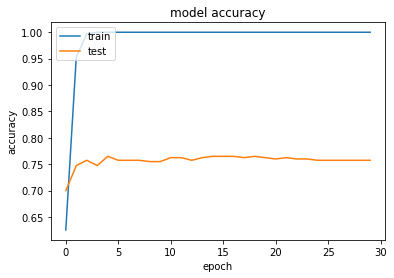

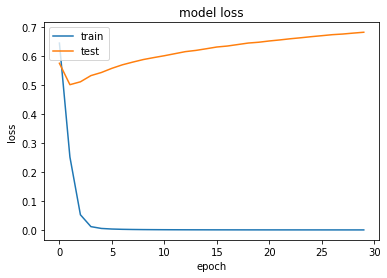

In [92]:
#Graphs for 30 epochs

print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predicting on test data (RNN model with pretrained embedding)

In [106]:
files_=glob.glob('C:/Users/91750/Desktop/VLG/test/*')

In [107]:
m=[pd.read_csv(filename,sep='\t',names=["text"],) for filename in files_]
test=pd.concat(m,axis=0)

In [108]:
test['text'] = test['text'].apply(remove_stop_words)

In [109]:
test['text'] = test['text'].apply(clean_data)

In [110]:
test['text'] = test['text'].apply(lematize)

In [112]:
test.head()

,text
0,good history doubt book cover history border p...
0,refinement needed s ton paper book overboard o...
0,wonderful handbook m new reading energy healin...
0,completely agree completely agree tomorrow sug...
0,wow d familiar appreciative graphic novel gave...


In [122]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(list(train_X))
 
train_X_seq  = tokenizer.texts_to_sequences(train_X) 

train_X_seq  = pad_sequences(train_X_seq, maxlen=100)

In [123]:
size_of_vocabulary_2=len(tokenizer.word_index) + 1
print(size_of_vocabulary_2)

19536


In [124]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(list(test['text']))

test_seq  = tokenizer.texts_to_sequences(test['text'])  

test_seq  = pad_sequences(test_seq, maxlen=100)

In [120]:
embedding_matrix = np.zeros((size_of_vocabulary_2, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [121]:
model=Sequential()

model.add(Embedding(size_of_vocabulary_2,300,weights=[embedding_matrix],input_length=100,trainable=True)) 

model.add(LSTM(100,return_sequences=True,activation='tanh'))

model.add(GlobalMaxPooling1D())

model.add(Dense(100))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

model.fit(np.array(train_X_seq),np.array(train_Y),epochs=5,verbose=1)

Epoch 1/5
63/63 [==============================] - 9s 125ms/step - loss: 0.5946 - acc: 0.6805
Epoch 2/5
63/63 [==============================] - 8s 125ms/step - loss: 0.3240 - acc: 0.8705
Epoch 3/5
63/63 [==============================] - 8s 129ms/step - loss: 0.1267 - acc: 0.9655
Epoch 4/5
63/63 [==============================] - 8s 134ms/step - loss: 0.0310 - acc: 0.9945
Epoch 5/5
63/63 [==============================] - 8s 132ms/step - loss: 0.0063 - acc: 0.9990


In [144]:
predictions=model.predict(test_seq)

In [149]:
Df=pd.DataFrame(predictions)

In [151]:
Df['predictions']=Df[0]

In [153]:
Df['predictions']=Df.predictions.apply(lambda x: 0 if (x<0.5) else 1)

In [163]:
Df.drop(0,axis=1,inplace=True)

In [164]:
Df.to_csv('Prediction.csv')